# Predict size of cluster from text content

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import scikitplot as skplt

from sklearn.utils import shuffle

%matplotlib inline

import lib.helper as helper

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Import various metrics by which to judge a model's performance
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Regression type measurements
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Import the ML models to try
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Tools for evaluating the model by running it repeatedly
# with variants of the data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

## 01.  Create features, labels, train-val-test split

In [4]:
# Load the corpus
df = pd.read_csv("working/disaster_kmeans_w2v_pca.csv")

In [5]:
# A quick utility function to pre-process the text
df["tokens"] = df["clean_text"].apply(helper.preprocess_description)
df['phrased_tokens'] = helper.get_phrased_nouns(df['clean_text'])

# Reasign huge clusters as outliers
cs_lookup = df['cluster'].value_counts().to_dict()
df['cluster'] = df['cluster'].apply(lambda x: -1 if (cs_lookup[x] > 1000) else x)

# Create variable for cluster size
df_size = pd.DataFrame(df['cluster'].value_counts())
df_size['cluster_label'] = df_size.index
df_size.columns = ['cluster_size', 'cluster']
df_size.head()

df = df.merge(df_size, on="cluster", how="left")

#df = df[df['cluster'] != -1]
df['cluster_size'] = np.where(df['cluster']==-1, 1.0, df['cluster_size'])

# Sort by date-order, latest last!
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df = df.sort_values("date_clean")

# Take a look at the features and labels
df[['cluster_size', 'tokens', 'phrased_tokens']].head()

,cluster_size,tokens,phrased_tokens
16010,418.0,"[quota, tsunami, debtquot, long, term, burden,...","[quota, tsunami, debtquot, euro, ing, euro]"
9184,275.0,"[pound, sterl, forecast, quotrisk, downsid, te...","[pound, sterl, forecast, quotrisk, downsid, eu..."
15522,418.0,"[quota, tsunami, debtquot, long, term, burden,...","[quota, tsunami, debtquot, euro, ing, euro]"
340,286.0,"[princess, ann, carri, work, despit, typhoon, ...","[princess_ann, typhoon_hagibi, japan, princess..."
423,472.0,"[princess, ann, carri, work, despit, typhoon, ...","[princess_ann, typhoon_hagibi, japan_typhoon, ..."


In [6]:
# vectorizer = TfidfVectorizer(decode_error="ignore", max_features=1000)
vectorizer = CountVectorizer(decode_error="ignore", max_features=7000)

# Create feature vectors
X = vectorizer.fit_transform(df['phrased_tokens'].apply(" ".join))

# Create Labels
y = np.asarray(df['cluster_size'].astype(float))

# Check that worked
print(X.shape, y.shape)

# Split the data randomly, save 'test' for final pass
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the data time-wise, save 'test' for final pass
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Ensure that the training data is shuffled at random
X_train, y_train = shuffle(X_train, y_train, random_state=42)

(23554, 7000) (23554,)


In [7]:
# Define the measurements we want to make (GridSearch will default to MSE)
scoring = {'MSE': make_scorer(mean_squared_error),
           'R2': make_scorer(r2_score)}

parameters = {'alpha':[0.01, 0.03, 0.05, 0.07, 0.1, 0.5, 1.0, 2.0],
              'l1_ratio': [1.0]}

model = ElasticNet()

# Perform cross-validated grid-search
clf = GridSearchCV(estimator=model,
                   cv=5,
                   param_grid=parameters,
                   return_train_score=True,
                   scoring=scoring,
                   refit="R2",
                   n_jobs=5)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

In [8]:
# Look at the performance of each hyperparameter combination
pd.DataFrame(clf.cv_results_)\
  [['params', 'mean_test_R2', 'mean_test_MSE']]\
  .sort_values("mean_test_R2", ascending=False)

,params,mean_test_R2,mean_test_MSE
1,"{'alpha': 0.03, 'l1_ratio': 1.0}",0.374893,13360.150574
0,"{'alpha': 0.01, 'l1_ratio': 1.0}",0.370356,13456.798673
2,"{'alpha': 0.05, 'l1_ratio': 1.0}",0.356440,13754.501187
3,"{'alpha': 0.07, 'l1_ratio': 1.0}",0.346189,13973.565567
4,"{'alpha': 0.1, 'l1_ratio': 1.0}",0.335619,14199.457268
5,"{'alpha': 0.5, 'l1_ratio': 1.0}",0.291689,15138.417628
6,"{'alpha': 1.0, 'l1_ratio': 1.0}",0.252255,15981.222879
7,"{'alpha': 2.0, 'l1_ratio': 1.0}",0.186540,17385.937942


In [9]:
print("** VALIDATION RESULTS **")
for method_name, scorer in scoring.items():
    print(method_name, scorer(X=X_test, y_true=y_test, estimator=clf))

** VALIDATION RESULTS **
MSE 16580.885523373054
R2 0.273855179780194


With all words; cv R2 = 0.24, val R2 = 0.36 (???)

With all non-nouns; cv R2 = 0.057, val R2 = 0.09

With nouns only; cv R2 = 0.31, val R2 = 0.45

With nouns only after remembering to shuffle the damn training data; cv R2 = 0.45, val R2 = 0.45
With nouns only after dropping outliers; cv R2 = 0.57, val R2 = 0.45

In [10]:
def help_get_coefs(fitted_model, feature_names):
    """
    Gets ordered table of coefficient names and magnitudes
    """
    df = pd.DataFrame({"name": feature_names,
                       "coefficient": fitted_model.coef_})
    
    # MAGNITUDES rather than VALUE determine importance
    df['abs_value'] = df['coefficient'].apply(abs)
    
    return df.sort_values("abs_value", ascending=False)


# In this call, retrieving final (selected and retrained)
# estimator from the grid search
coef_table = help_get_coefs(clf.best_estimator_, list(vectorizer.get_feature_names()))

coef_table

,name,coefficient,abs_value
4867,pompeii,131.178182,131.178182
4034,met_offic,-121.607430,121.607430
6421,uk_britain,-108.078632,108.078632
2052,environ_agenc,-107.618110,107.618110
669,bori_johnson,-107.398115,107.398115
...,...,...,...
2612,griffin,0.000000,0.000000
2610,grid,0.000000,0.000000
2608,gretna,0.000000,0.000000
2607,greta_thunberg,-0.000000,0.000000


In [11]:
coef_table.head(30)

,name,coefficient,abs_value
4867,pompeii,131.178182,131.178182
4034,met_offic,-121.607430,121.607430
6421,uk_britain,-108.078632,108.078632
2052,environ_agenc,-107.618110,107.618110
669,bori_johnson,-107.398115,107.398115
1414,coronaviru_uk,-106.163791,106.163791
5983,storm_denni,-97.099835,97.099835
2576,grassland,-94.060454,94.060454
5981,storm_ciara,-91.556278,91.556278
1849,drought,87.416082,87.416082


In [12]:
# How many features ultimately selected?
# (they're regularised to NEAR zero, so need a tolerance)
coef_table[coef_table['abs_value'] >= 2.0]

,name,coefficient,abs_value
4867,pompeii,131.178182,131.178182
4034,met_offic,-121.607430,121.607430
6421,uk_britain,-108.078632,108.078632
2052,environ_agenc,-107.618110,107.618110
669,bori_johnson,-107.398115,107.398115
...,...,...,...
2339,freez,2.112023,2.112023
5666,sherborn,2.098901,2.098901
6353,trust,2.085683,2.085683
3681,lion,2.035733,2.035733


In [13]:
# What features suck?
coef_table[coef_table['abs_value'] <= 0.01]

,name,coefficient,abs_value
3596,leed_flood,0.002497,0.002497
4553,offic_south,0.000000,0.000000
6588,von,0.000000,0.000000
4543,offic_gloucestershir,-0.000000,0.000000
4544,offic_ici,-0.000000,0.000000
...,...,...,...
2612,griffin,0.000000,0.000000
2610,grid,0.000000,0.000000
2608,gretna,0.000000,0.000000
2607,greta_thunberg,-0.000000,0.000000


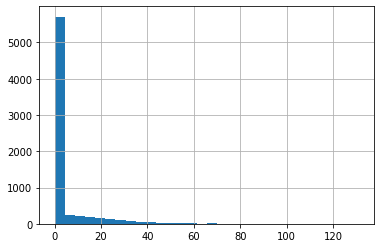

In [14]:
coef_table['abs_value'].hist(bins=30)

## Diagnostic Plots
I'm, to some degree, improvising my own because no single python package quite does everything I'd expect R to do for a linear regression...

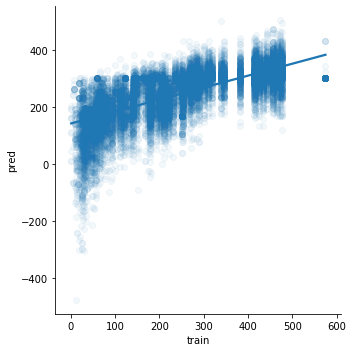

In [15]:
temp_df = pd.DataFrame({"train": y_train,
                        "pred": y_pred})

# Note this isn't the line of the actual regression model.
sns.lmplot(x="train", y="pred", data=temp_df, scatter_kws={"alpha":0.05})

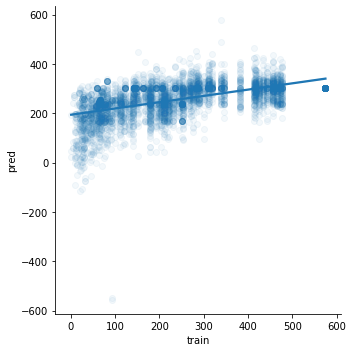

In [16]:
temp_df = pd.DataFrame({"train": y_test,
                        "pred": clf.best_estimator_.predict(X_test)})

# Note this isn't the line of the actual regression model.
sns.lmplot(x="train", y="pred", data=temp_df, scatter_kws={"alpha":0.05})

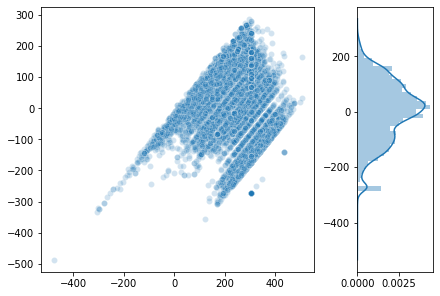

In [17]:
def help_plot_residuals(fitted_model, X, y):
    """
    Utility function:  Plot residual values for a given model
    and features + predictions
    """
    predicted = fitted_model.predict(X)
    residuals = predicted - y
    
    f = plt.figure(constrained_layout=True)
    gs = f.add_gridspec(3, 3)
    f_ax0 = f.add_subplot(gs[:, :-1])
    f_ax1 = f.add_subplot(gs[:, -1])
    
    # Residuals vs predicted
    sns.scatterplot(x=predicted, y=residuals, alpha=0.2, ax=f_ax0)
    
    # Hist of residuals
    sns.distplot(a=residuals, hist=True, vertical=True, ax=f_ax1)


help_plot_residuals(clf.best_estimator_, X_train, y_train)

In [18]:
# Fit a traditional Linear Regression Model so that we can examine the p-values and r2 values
# of different features

import scipy.stats as stats
import statsmodels.api as sm
from patsy import dmatrices

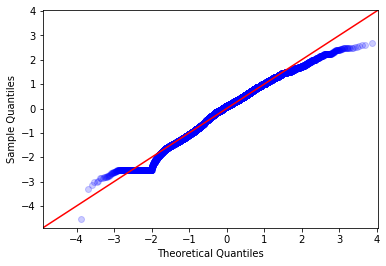

In [19]:
# Q-Q plot to gauge suitability of normality assumption
res = clf.best_estimator_.predict(X_train) - y_train

fig = sm.qqplot(res, stats.t, fit=True, line='45', alpha=0.2)
plt.show()

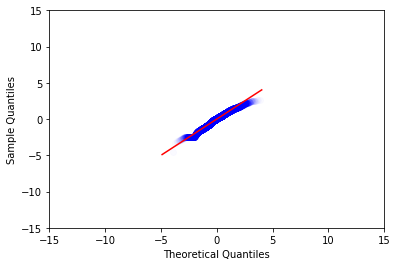

In [20]:
# Q-Q plot to gauge suitability of normality assumption
res = clf.best_estimator_.predict(X_train) - y_train

fig = sm.qqplot(res, stats.t, fit=True, line='45', alpha=0.02)
fig.axes[0].set_xlim(-15, 15)
fig.axes[0].set_ylim(-15, 15)
plt.show()

## Examine feature significance using an equivalent model in StatsModels

In [21]:
df_stats = pd.DataFrame(data=X_train.todense(), columns=list(vectorizer.get_feature_names()))
df_stats.head()

df_stats['StorySize'] = y_train